In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


MAE: 133.84
MSE: 35082.19
R²: 0.89

Actual vs Predicted Sales:
     Actual Sales  Predicted Sales
7            2804      2966.187744
27           2422      2632.790039
47           3406      3289.280518
67           2828      2752.005371
87           3542      3413.135254
107          2898      2812.573242
127          2268      2280.502441
147          2842      2815.225830
167          1918      1905.968384
187          2557      2506.834229
207          2170      2193.749756
227          2301      2377.540771
247          2674      2609.464600
267          3374      3261.163330
287          3178      3170.814453
307          3522      3438.703125
327          2632      2672.724609
347          2156      2269.715820
367          2380      2341.865234
387          1778      1982.812744


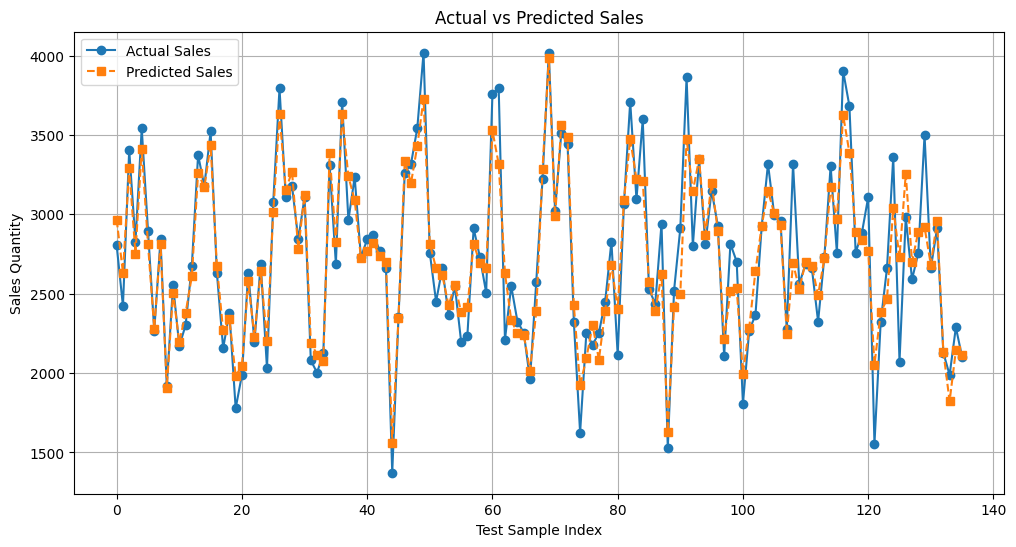

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

# Load the dataset
file_path = "drive/MyDrive/Datasets/sales_data_new.csv"
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df[df['date'] <= '2024-10-01']

# Create complete grid of dates, categories, and warehouses
all_dates = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='MS')
categories = df['product_category'].unique()
warehouses = df['warehouse_location'].unique()
index = pd.MultiIndex.from_product([all_dates, categories, warehouses], names=['date', 'product_category', 'warehouse_location'])
df_grouped = df.groupby(['date', 'product_category', 'warehouse_location'])['product_sales_quantity'].sum().reindex(index, fill_value=0).reset_index()

# Feature Engineering
df_grouped.sort_values(['product_category', 'warehouse_location', 'date'], inplace=True)
for lag in [1, 2, 3]:
    df_grouped[f'lag_{lag}'] = df_grouped.groupby(['product_category', 'warehouse_location'])['product_sales_quantity'].shift(lag)

window_sizes = [3, 6]
for window in window_sizes:
    df_grouped[f'rolling_mean_{window}'] = df_grouped.groupby(['product_category', 'warehouse_location'])['product_sales_quantity'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    df_grouped[f'rolling_std_{window}'] = df_grouped.groupby(['product_category', 'warehouse_location'])['product_sales_quantity'].transform(lambda x: x.rolling(window, min_periods=1).std())

df_grouped['month_sin'] = np.sin(2 * np.pi * df_grouped['date'].dt.month / 12)
df_grouped['month_cos'] = np.cos(2 * np.pi * df_grouped['date'].dt.month / 12)
df_grouped['year'] = df_grouped['date'].dt.year
df_grouped['time_idx'] = (df_grouped['date'].dt.year - df_grouped['date'].dt.year.min()) * 12 + (df_grouped['date'].dt.month - df_grouped['date'].dt.month.min())
df_grouped.fillna(0, inplace=True)

# One-hot encode categorical variables
df_grouped = pd.get_dummies(df_grouped, columns=['product_category', 'warehouse_location'], drop_first=False)

# Define features and target
X = df_grouped.drop(columns=['date', 'product_sales_quantity'])
y = df_grouped['product_sales_quantity']

# Split data with time series consideration
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Hyperparameter tuning with XGBoost's built-in CV
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'random_state': 42
}

cv_results = xgb.cv(params, dtrain, num_boost_round=200, nfold=5, metrics="rmse", early_stopping_rounds=10)
best_n_estimators = len(cv_results)

# Train final model with best number of trees
best_model = xgb.XGBRegressor(**params, n_estimators=best_n_estimators)
best_model.fit(X_train, y_train)

# Evaluate the model
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

# Display actual vs. predicted sales
comparison_df = pd.DataFrame({'Actual Sales': y_test, 'Predicted Sales': y_pred})
print("\nActual vs Predicted Sales:")
print(comparison_df.head(20))

# Plot actual vs predicted sales
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Sales', marker='o')
plt.plot(y_pred, label='Predicted Sales', marker='s', linestyle='dashed')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Test Sample Index')
plt.ylabel('Sales Quantity')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")
"""
R² closer to 1 → better model performance.
R² closer to 0 or negative → poor performance.
"""

R² Score: 0.8867


'\nR² closer to 1 → better model performance.\nR² closer to 0 or negative → poor performance.\n'

In [5]:
import numpy as np

rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
"""
Lower RMSE means better predictions.
"""

RMSE: 187.3024


'\nLower RMSE means better predictions.\n'

In [6]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")
"""
If MAPE = 10%, it means predictions are off by 10% on average.
"""

MAPE: 5.09%


'\nIf MAPE = 10%, it means predictions are off by 10% on average.\n'

In [ ]:
best_model.save_model('/content/drive/MyDrive/MLmodels/xgboost_model.json')